# Austin TX Crime Data GeoAI Project

## Loading Austin Crime Dataset
Downloaded full dataset from [website](https://data.austintexas.gov/Public-Safety/Crime-Reports/fdj4-gpfu/about_data).

In [86]:
import pandas as pd
import numpy as np

# Read the JSON file into a pandas DataFrame
crime_df = pd.read_csv('../data/Crime_Reports_20250419.csv')  # Replace with your actual file path

# Display basic info
print(f"Data shape: {crime_df.shape}")


Data shape: (2614910, 19)


## Data Cleaning
Removing NaNs in Census Block Group

In [87]:
# 1. Check initial size and NaN count
original_size = len(crime_df)
nan_count = crime_df['Census Block Group'].isna().sum()

print(f"Original dataset size: {original_size:,} records")
print(f"Records with missing Census Block Group: {nan_count:,} ({nan_count/original_size*100:.2f}%)")

# 2. Remove rows with NaN in Census Block Group
crime_df = crime_df.dropna(subset=['Census Block Group']).copy()

# 3. Analyze the impact
new_size = len(crime_df)
removed_count = original_size - new_size

print(f"\nAfter removing NaN Census Block Group records:")
print(f"New dataset size: {new_size:,} records")
print(f"Records removed: {removed_count:,} ({removed_count/original_size*100:.2f}%)")
print(f"Percentage of data remaining: {new_size/original_size*100:.2f}%")

Original dataset size: 2,614,910 records
Records with missing Census Block Group: 64,967 (2.48%)

After removing NaN Census Block Group records:
New dataset size: 2,549,943 records
Records removed: 64,967 (2.48%)
Percentage of data remaining: 97.52%


## Descriptive Statistics

### Top Offences

Top 15 Most Frequent Offenses:
Highest Offense Description
BURGLARY OF VEHICLE               256749
THEFT                             229292
FAMILY DISTURBANCE                212659
CRIMINAL MISCHIEF                 144131
ASSAULT W/INJURY-FAM/DATE VIOL     89371
BURGLARY OF RESIDENCE              82368
DWI                                72344
HARASSMENT                         71729
PUBLIC INTOXICATION                69187
DISTURBANCE - OTHER                67900
AUTO THEFT                         65195
ASSAULT WITH INJURY                56456
THEFT BY SHOPLIFTING               55989
CUSTODY ARREST TRAFFIC WARR        47365
CRIMINAL TRESPASS                  46166
Name: count, dtype: int64

Original dataset size: 2549943
Filtered dataset size (top 15 offenses only): 1566901
Percentage of total crimes: 61.45%

Total crimes in top 15 offenses: 1566901


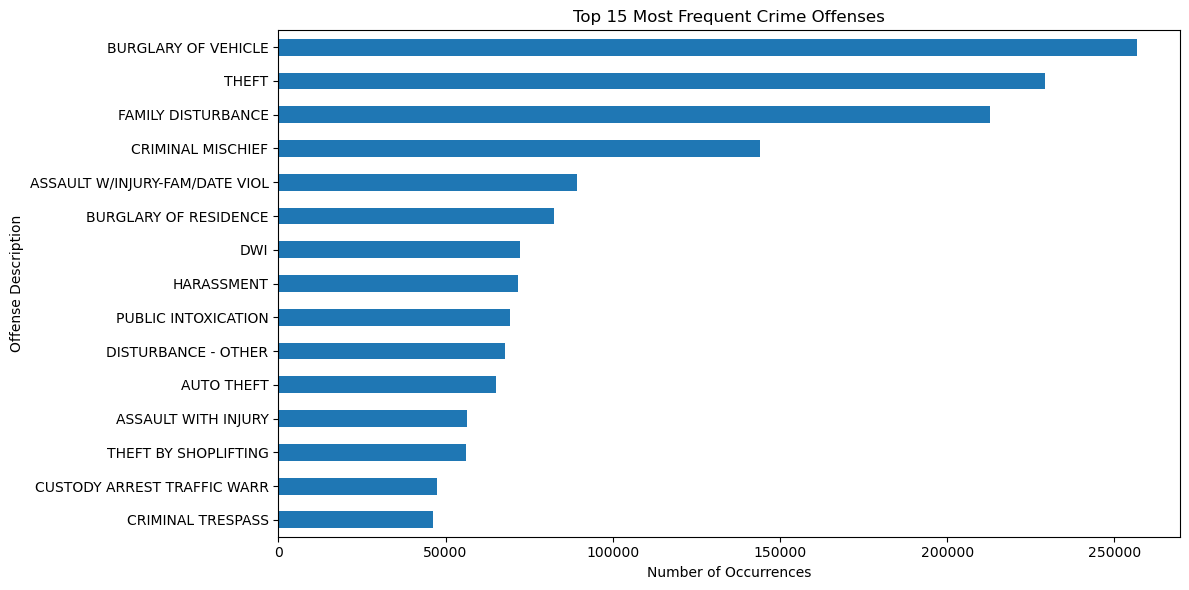

In [88]:

# 1. Get the top 15 most frequent offense descriptions
top_15_offenses = crime_df['Highest Offense Description'].value_counts().head(15)

print("Top 15 Most Frequent Offenses:")
print(top_15_offenses)

# 2. Filter the dataset to only include these top 15 offenses
top_15_filter = crime_df['Highest Offense Description'].isin(top_15_offenses.index)
filtered_df = crime_df[top_15_filter].copy()

print(f"\nOriginal dataset size: {len(crime_df)}")
print(f"Filtered dataset size (top 15 offenses only): {len(filtered_df)}")
print(f"Percentage of total crimes: {len(filtered_df)/len(crime_df)*100:.2f}%")

# 3. Calculate the sum of all datapoints in these top 15 offenses
total_top_15_crimes = top_15_offenses.sum()
print(f"\nTotal crimes in top 15 offenses: {total_top_15_crimes}")

# Optional: Visualize the top 15 offenses
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
top_15_offenses.sort_values().plot(kind='barh')
plt.title('Top 15 Most Frequent Crime Offenses')
plt.xlabel('Number of Occurrences')
plt.ylabel('Offense Description')
plt.tight_layout()
plt.show()

### Occurence Time of Day

In [90]:
def parse_time(input_time):
    """Handle 24:00 conversion and all edge cases"""
    try:
        time_int = int(input_time)
        # Handle 2400 specifically
        if time_int == 2400:
            return '00:00'
        time_str = str(time_int).zfill(4)
        return f"{time_str[:2]}:{time_str[2:]}"
    except (ValueError, TypeError):
        return None

hourly_counts = (
    crime_df['Occurred Time']
    .apply(parse_time)
    .dropna()
    .str[:2]
    .value_counts()
    .sort_index()
)

# Print results (now guaranteed 00-23)
print("Crime Counts by Hour (00-23)")
print("----------------------------")
print(f"{'Hour':<6} {'Count':>10}")
for hour in [f"{i:02d}" for i in range(24)]:  # Force 00-23 order
    print(f"{hour}:00   {hourly_counts.get(hour, 0):>10,}")

Crime Counts by Hour (00-23)
----------------------------
Hour        Count
00:00      164,298
01:00      108,153
02:00      106,604
03:00       70,908
04:00       46,573
05:00       34,202
06:00       37,258
07:00       54,951
08:00       76,069
09:00       77,239
10:00       90,511
11:00       89,131
12:00      172,142
13:00       95,947
14:00      103,015
15:00      109,323
16:00      116,190
17:00      135,797
18:00      144,439
19:00      134,168
20:00      138,752
21:00      142,630
22:00      158,842
23:00      142,753


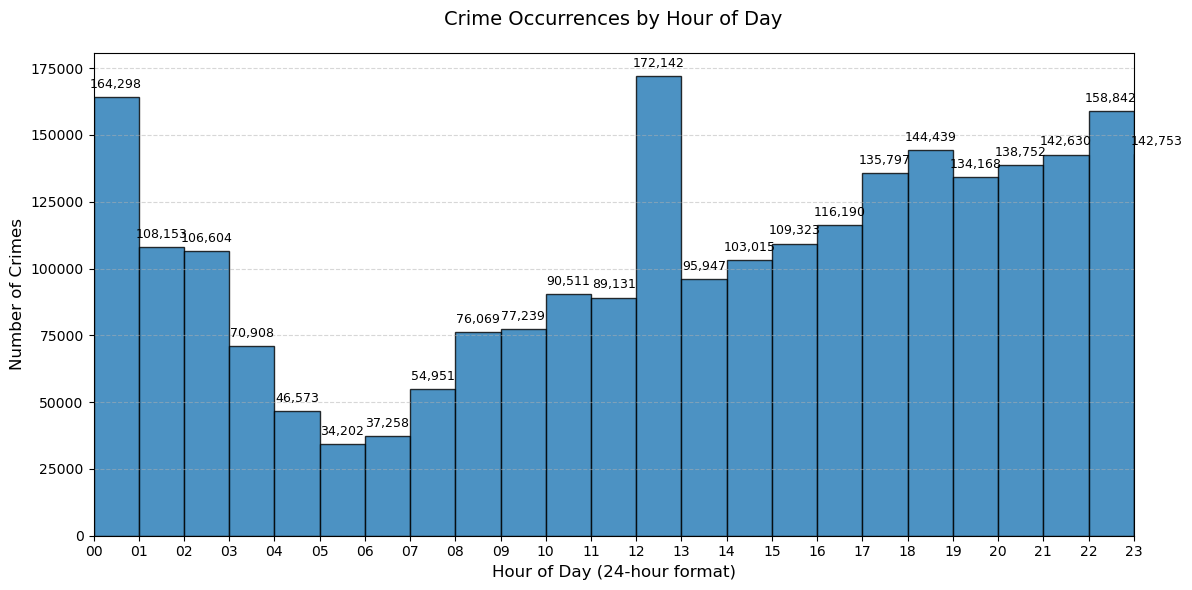

In [91]:
import matplotlib.pyplot as plt

# Prepare the data (using our previous parsing)
hours = (
    crime_df['Occurred Time']
    .apply(parse_time)
    .dropna()
    .str[:2]
    .astype(int)  # Convert hour strings to integers
)

# Create the histogram
plt.figure(figsize=(12, 6))
n, bins, patches = plt.hist(hours, 
                           bins=24, 
                           range=(0, 24),
                           edgecolor='black',
                           color='#1f77b4',
                           alpha=0.8)

# Formatting
plt.title('Crime Occurrences by Hour of Day', pad=20, fontsize=14)
plt.xlabel('Hour of Day (24-hour format)', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.xticks(range(24), [f"{h:02d}" for h in range(24)])
plt.xlim(0, 23)

# Add grid and value labels
plt.grid(axis='y', linestyle='--', alpha=0.5)
for i in range(24):
    plt.text(bins[i]+0.5, n[i]+0.02*max(n), 
             f"{int(n[i]):,}", 
             ha='center', 
             fontsize=9)

plt.tight_layout()
plt.show()

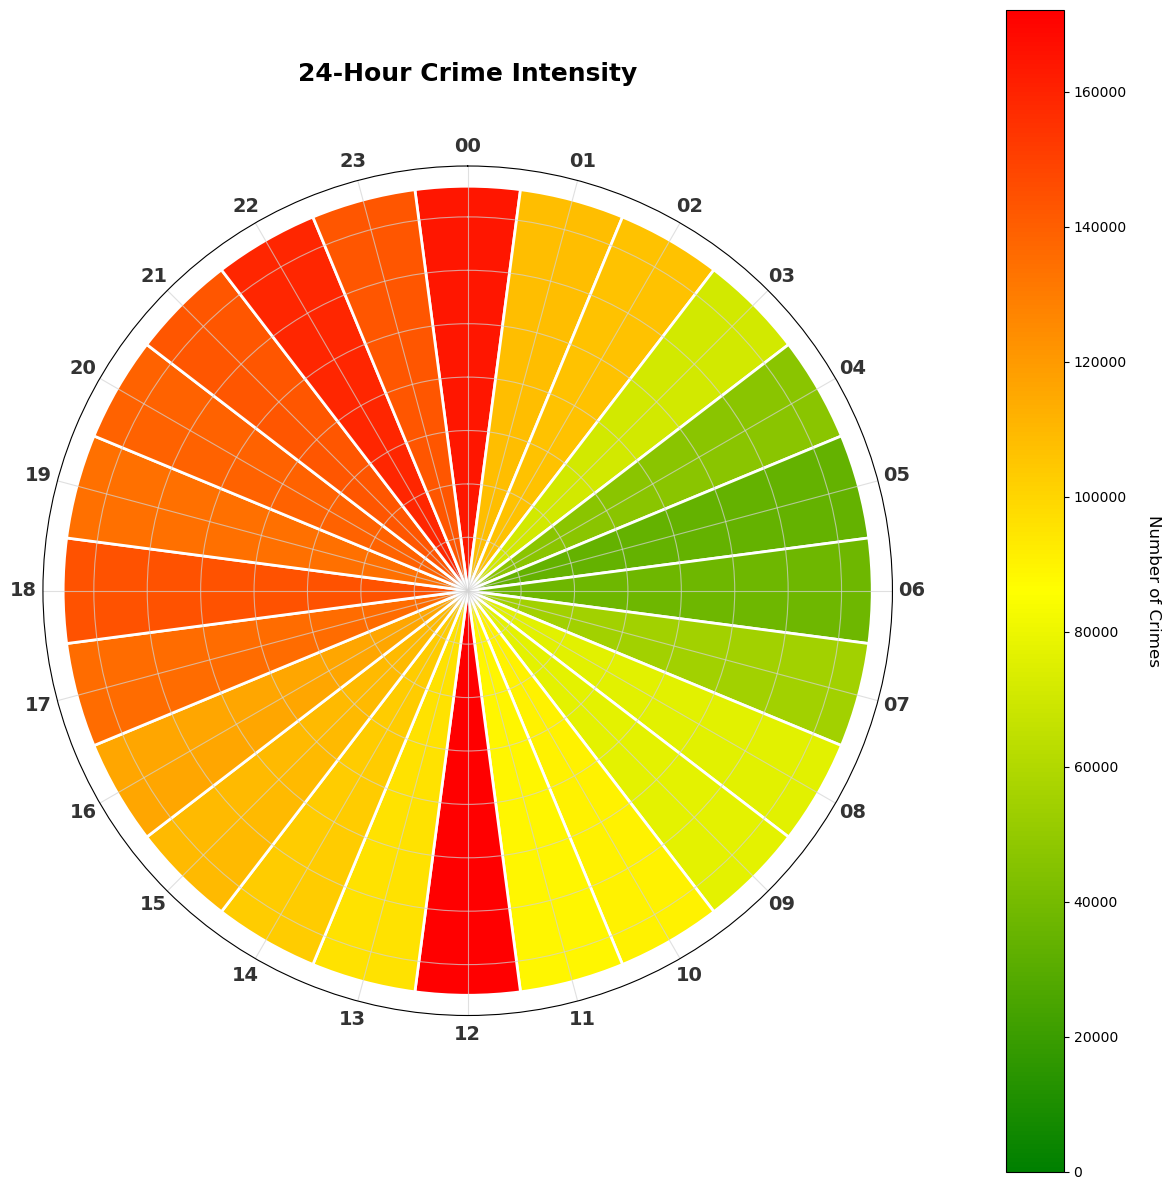

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# 1. DATA PREP (verified)
hourly_counts = (
    crime_df['Occurred Time']
    .apply(parse_time)
    .dropna()
    .str[:2]
    .astype(int)
    .value_counts()
    .reindex(range(24), fill_value=0)  # Force all hours
    .sort_index()  # 00-23 order
)

# 2. VISUALIZATION
plt.figure(figsize=(12, 12))
ax = plt.subplot(111, polar=True)

# Clock configuration (REAL CLOCK)
ax.set_theta_direction(-1)  # Clockwise 
ax.set_theta_offset(np.pi/2)  # Midnight at top
theta = np.linspace(0, 2*np.pi, 24, endpoint=False)

# Color intensity (Yellow -> Red)
cmap = LinearSegmentedColormap.from_list('crime', ['green', 'yellow', 'red'])
colors = cmap(hourly_counts/hourly_counts.max())

# Plot solid bars
bars = ax.bar(
    theta, 
    [hourly_counts.max()*1.1]*24,  # Full-height uniform bars
    width=2*np.pi/24, 
    color=colors,
    edgecolor='white',
    linewidth=2
)

# 3. LABELING
ax.set_xticks(theta)
ax.set_xticklabels(
    [f'{h:02d}' for h in range(24)],
    fontsize=14,
    fontweight='bold',
    color='#333333'
)

# 4. CLEAN LAYOUT
ax.set_yticklabels([])
ax.grid(color='lightgray', linestyle='-', alpha=0.7)

# 5. COLOR LEGEND
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, hourly_counts.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.1)
cbar.set_label('Number of Crimes', rotation=270, labelpad=25, fontsize=12)

plt.title('24-Hour Crime Intensity\n', fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### Location Type

Top 15 Location Types:
Location Type
RESIDENCE / HOME                           989190
HWY / ROAD / ALLEY/ STREET/ SIDEWALK       553742
PARKING /DROP LOT/ GARAGE                  324257
COMMERCIAL / OFFICE BUILDING               156159
OTHER / UNKNOWN                             86016
DEPARTMENT / DISCOUNT STORE                 47924
HOTEL / MOTEL / ETC.                        43337
GROCERY / SUPERMARKET                       40034
RESTAURANT                                  38984
CONVENIENCE STORE                           34779
BAR / NIGHTCLUB                             28561
GOVERNMENT / PUBLIC BUILDING                28276
DRUG STORE / DOCTOR'S OFFICE / HOSPITAL     27843
SERVICE/ GAS STATION                        21259
SPECIALTY  STORE                            18356
Name: count, dtype: int64

Total crimes in top 15 offenses: 2438717


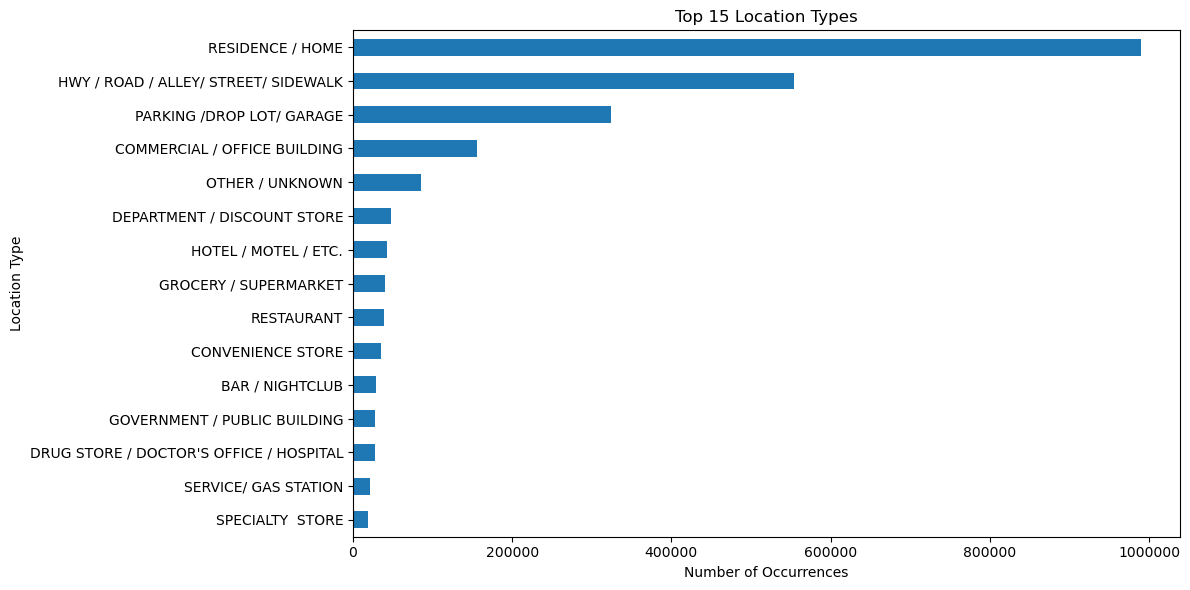

In [93]:

# 1. Get the top 15 most frequent offense descriptions
top_15_offenses = crime_df['Location Type'].value_counts().head(15)

print("Top 15 Location Types:")
print(top_15_offenses)

# 2. Filter the dataset to only include these top 15 offenses
top_15_filter = crime_df['Location Type'].isin(top_15_offenses.index)
filtered_df = crime_df[top_15_filter].copy()

# 3. Calculate the sum of all datapoints in these top 15 offenses
total_top_15_crimes = top_15_offenses.sum()
print(f"\nTotal crimes in top 15 offenses: {total_top_15_crimes}")

# Optional: Visualize the top 15 offenses
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
top_15_offenses.sort_values().plot(kind='barh')
plt.title('Top 15 Location Types')
plt.xlabel('Number of Occurrences')
plt.ylabel('Location Type')

# Add this one line to disable scientific notation:
plt.ticklabel_format(style='plain', axis='x')  # Changed line

plt.tight_layout()
plt.show()